# 1. Introuction

This notebook outlines the creation, compilation, and training of a binary classification model to distinguish between food and non-food. The simple Convolutional Neural Network (CNN), [EfficientNetB0](https://pytorch.org/vision/main/models/generated/torchvision.models.efficientnet_b0.html), will be used to solve this task.

The database used to collect non-food images is ADE20K, which can be downloaded from this [link](https://www.kaggle.com/datasets/ipythonx/ade20k-scene-parsing).

# 2. Importing Libraries

In [1]:
#!pip install onnxruntime
#!pip install onnxruntime-gpu
import os
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import torch
import torchvision
import torch._dynamo
import itertools
import seaborn as sns

from torchvision.transforms import v2
from torchinfo import summary
from pathlib import Path
from torchvision import datasets
from typing import List
from sklearn.metrics import confusion_matrix, roc_curve, roc_auc_score

# Import custom librarieses.model
from modules.helper_functions import create_dataloaders, set_seeds, display_random_images
from modules.engine import Trainer

# Define some constants
NUM_WORKERS = os.cpu_count()
BATCH_SIZE = 64
TARGET_RECALL = 1.0
SEED = 42

# Define target data directory
target_dir_name = f"../data/classif_food_nofood"

# Setup training and test directories
target_dir = Path(target_dir_name)
train_dir = target_dir / "train"
test_dir = target_dir / "test"
target_dir.mkdir(parents=True, exist_ok=True)

# Create target model directory
model_dir = Path("../models")

# Set seeds
set_seeds(SEED)

In [2]:
# Set device
device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Device: {device}")

Device: cuda


# 3. Creating Dataloaders

In [3]:
# Image sizes
IMG_SIZE = 224

# Manual transforms for the training dataset
manual_transforms = v2.Compose([     
    v2.Resize((256, 256)),      
    v2.RandomCrop((IMG_SIZE, IMG_SIZE)),    
    v2.ToImage(),
    v2.ToDtype(torch.float32, scale=True),    
])

# EfficientNetB0 transforms

# Manual transforms for the training dataset
manual_transforms_aug_norm_train_effb0 = v2.Compose([    
    v2.TrivialAugmentWide(),
    v2.Resize((256, 256)),
    v2.RandomCrop((IMG_SIZE, IMG_SIZE)),    
    v2.ToImage(),
    v2.ToDtype(torch.float32, scale=True),
    v2.Normalize(mean=[0.485, 0.456, 0.406],
                std=[0.229, 0.224, 0.225]) 
])

# Manual transforms for the test dataset
manual_transforms_aug_norm_test_effb0 = v2.Compose([    
    v2.Resize((256, 256)),
    v2.CenterCrop((IMG_SIZE, IMG_SIZE)),    
    v2.ToImage(),
    v2.ToDtype(torch.float32, scale=True),
    v2.Normalize(mean=[0.485, 0.456, 0.406],
                std=[0.229, 0.224, 0.225]) 
])

In [4]:
# Create data loaders for EfficientNetB0
train_dataloader_effb0, test_dataloader_effb0, class_names = create_dataloaders(
    train_dir=train_dir,
    test_dir=test_dir,
    train_transform=manual_transforms_aug_norm_train_effb0,
    test_transform=manual_transforms_aug_norm_test_effb0,
    batch_size=BATCH_SIZE
)

# 4. Image Visualization

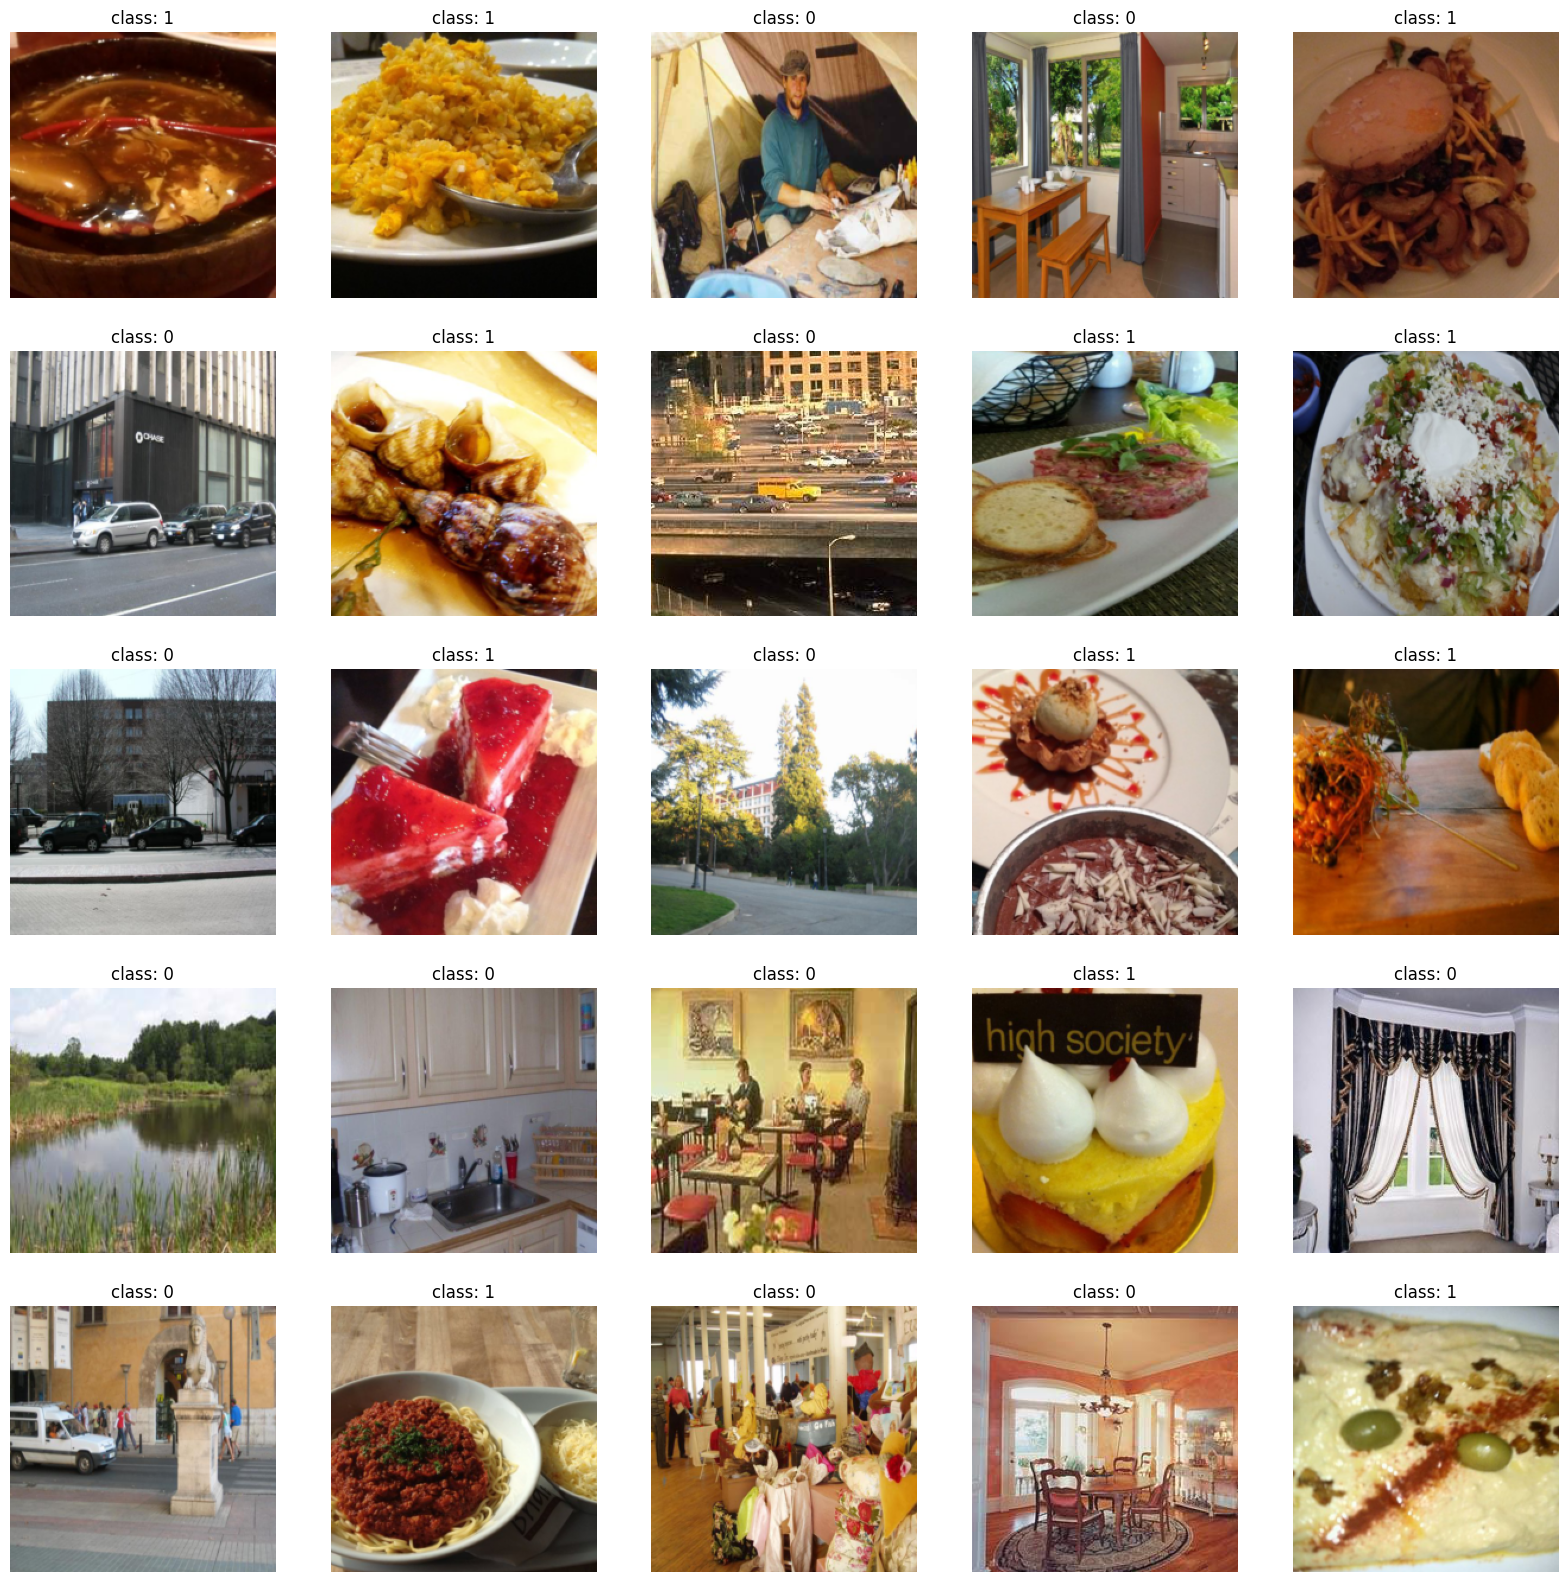

In [5]:
train_data = datasets.ImageFolder(train_dir, transform=manual_transforms)
display_random_images(train_data,
                      n=25,
                      classes=class_names,
                      rows=5,
                      cols=5,
                      display_shape=False,
                      seed=None)

# 5. Training

In [6]:
# Create an EfficientNet-B0 Model
def create_effnetb0(
        transfer_learning: bool=True,
        class_names: List[str]=None,
        seed: int=SEED,
        dropout: float=0.2,
        device: torch.device = "cuda" if torch.cuda.is_available() else "cpu"
        ):
    """Creates an EfficientNetB0 feature extractor model and transforms.

    Args:
        num_classes (int, optional): number of classes in the classifier head.
            Defaults to len(class_names)
        seed (int, optional): Random seed to seed model weights. Defaults to SEED.
        dropout (float, optional): Dropout rate. Defaults to 0.2.

    Returns:
        model (torch.nn.Module): EffNetB0 feature extractor model.
        transforms (torchvision.transforms): Image transforms.
    """
    # Create EffNetB0 pretrained weights, transforms and model
    #if transfer_learning:
    #    weights = torchvision.models.EfficientNet_B0_Weights.DEFAULT # .DEFAULT = best available weights
        
    # Load pretrained weights
    weights = torchvision.models.EfficientNet_B0_Weights.DEFAULT # .DEFAULT = best available weights 
    model = torchvision.models.efficientnet_b0(weights=weights).to(device)

    # Freeze the base parameters
    for parameter in model.parameters():
        parameter.requires_grad = not(transfer_learning)

    # Set the seeds
    set_seeds(seed)

    # Get the length of class_names (one output unit for each class)
    output_shape = len(class_names)

    # Recreate the classifier layer and seed it to the target device
    model.classifier = torch.nn.Sequential(
        torch.nn.Dropout(p=dropout, inplace=True), 
        torch.nn.Linear(in_features=1280, 
                        out_features=output_shape, # same number of output units as our number of classes
                        bias=True)).to(device)
    
    #model.classifier = torch.nn.Sequential(
    #    torch.nn.Dropout(p=dropout, inplace=True),
    #    torch.nn.Linear(in_features=1280, out_features=1024, bias=True),  # First hidden layer
    #    torch.nn.ReLU(),  # Activation function
    #    torch.nn.Dropout(p=dropout, inplace=True),
    #    torch.nn.Linear(in_features=1024, out_features=512, bias=True),  # Second hidden layer (optional)
    #    torch.nn.ReLU(),  # Activation function
    #    torch.nn.Linear(in_features=512, out_features=output_shape)  # Output layer
    #).to(device)
        
    return model, weights

In [ ]:
# Instantiate the model
effnetb0_cl_model, _ = create_effnetb0(
    transfer_learning=False,
    class_names=class_names
    )

# Compile the model
effnetb0_cl_model = torch.compile(effnetb0_cl_model, backend='aot_eager')

# And a summary
summary(effnetb0_cl_model,
        input_size=(BATCH_SIZE, 3, IMG_SIZE, IMG_SIZE), # try swapping this for "random_input_image_error"
        col_names=["input_size", "output_size", "num_params", "trainable"],
        col_width=20,
        row_settings=["var_names"])

c:\Users\ssre_\.conda\envs\.venv_pytorch_gpu\Lib\site-packages\onnxscript\converter.py:820: FutureWarning: 'onnxscript.values.Op.param_schemas' is deprecated in version 0.1 and will be removed in the future. Please use '.op_signature' instead.
  param_schemas = callee.param_schemas()
c:\Users\ssre_\.conda\envs\.venv_pytorch_gpu\Lib\site-packages\onnxscript\converter.py:820: FutureWarning: 'onnxscript.values.OnnxFunction.param_schemas' is deprecated in version 0.1 and will be removed in the future. Please use '.op_signature' instead.
  param_schemas = callee.param_schemas()
W0111 12:15:04.840000 15312 site-packages\torch\_dynamo\convert_frame.py:844] [9/8] torch._dynamo hit config.cache_size_limit (8)
W0111 12:15:04.840000 15312 site-packages\torch\_dynamo\convert_frame.py:844] [9/8]    function: '_scale' (c:\Users\ssre_\.conda\envs\.venv_pytorch_gpu\Lib\site-packages\torchvision\ops\misc.py:251)
W0111 12:15:04.840000 15312 site-packages\torch\_dynamo\convert_frame.py:844] [9/8]    last

Epoch: 15 | train_loss: 0.0072 | train_acc: 0.9976 | fpr_at_recall: 0.1690 | train_time: 2m37s | test_loss: 0.0037 | test_acc: 0.9991 | fpr_at_recall: 0.0077 | test_time: 1m6s | lr: 0.0000100000


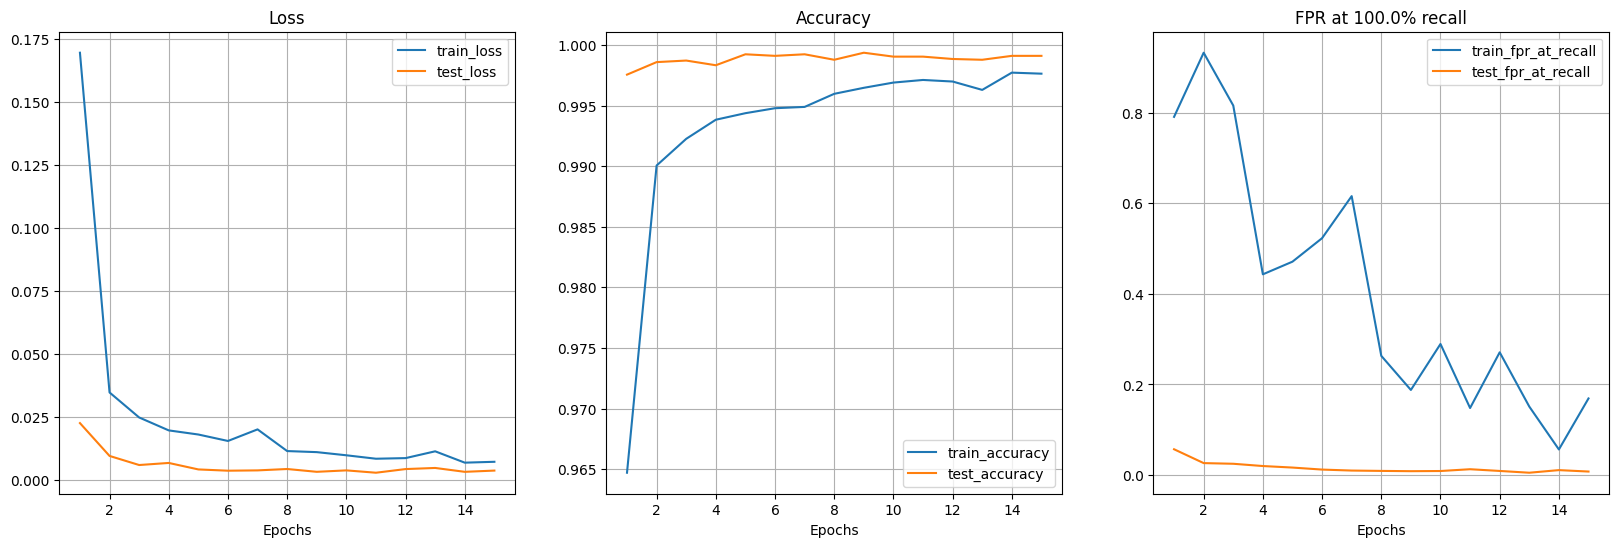

[INFO] Saving model to: ..\models\effnetb0_2025-01-05_epoch15.pth
[INFO] Saving model to: ..\models\effnetb0_2025-01-05.pth


In [8]:
model_type="effnetb0_2025-01-05"
EPOCHS = 15
LR = 0.00001
ACCUMULATION_STEPS = 1
model_name = f"{model_type}"
effnetb0_cl_model_name = model_name + ".pth"
    
optimizer = torch.optim.AdamW(
    params=effnetb0_cl_model.parameters(),
    lr=LR,
    betas=(0.9, 0.999),
    weight_decay=1e-4
    )

# Create loss function
loss_fn = torch.nn.CrossEntropyLoss()

# Set scheduler
#scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=EPOCHS, eta_min=1e-6)
#scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=10, gamma=0.1)
#scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=3)

# Set seeds
set_seeds(SEED)

# And train...
train = Trainer(
    model=effnetb0_cl_model,
    save_best_model=True,
    mode="all", # all epochs to be saved
    device=device)

effnetb0_cl_model_results = train.fit(
    target_dir=model_dir,
    model_name=effnetb0_cl_model_name,
    train_dataloader=train_dataloader_effb0,
    test_dataloader=test_dataloader_effb0,
    optimizer=optimizer,
    loss_fn=loss_fn,
    recall_threshold=TARGET_RECALL,
    scheduler=None,
    epochs=EPOCHS,
    amp=True, #amp equal to True results in inestability
    enable_clipping=False
    )

In [9]:
effnetb0_cl_model_results

epoch  train_loss  train_acc  train_fpr_at_recall  train_time [s]  \
0       1    0.169494   0.964714             0.790392      186.778639   
1       2    0.034720   0.990051             0.931940      158.824668   
2       3    0.024793   0.992252             0.815367      157.081242   
3       4    0.019664   0.993828             0.442917      161.278487   
4       5    0.018031   0.994367             0.470839      158.100452   
5       6    0.015473   0.994777             0.522684      160.787555   
6       7    0.020066   0.994885             0.615470      157.689472   
7       8    0.011466   0.995964             0.263011      156.495615   
8       9    0.011042   0.996461             0.187716      158.463523   
9      10    0.009792   0.996892             0.289164      157.558070   
10     11    0.008426   0.997108             0.147845      156.913167   
11     12    0.008672   0.996979             0.270804      160.772026   
12     13    0.011368   0.996288             0.151035      158.255120   
13     14    0.006866   0.997712             0.056417      157.744304   
14     15    0.007211   0.997626             0.169006      157.356801   

    test_loss  test_acc  test_fpr_at_recall  test_time [s]       lr  
0    0.022561  0.997546            0.056877      77.275225  0.00001  
1    0.009534  0.998580            0.026314      66.620951  0.00001  
2    0.005928  0.998709            0.024850      65.544755  0.00001  
3    0.006752  0.998321            0.019846      67.163758  0.00001  
4    0.004179  0.999225            0.016471      65.922143  0.00001  
5    0.003678  0.999096            0.012029      65.826726  0.00001  
6    0.003800  0.999225            0.009855      66.030699  0.00001  
7    0.004348  0.998773            0.009096      65.278507  0.00001  
8    0.003235  0.999354            0.008477      65.688814  0.00001  
9    0.003802  0.999032            0.008859      65.640081  0.00001  
10   0.002874  0.999032            0.012793      65.577857  0.00001  
11   0.004322  0.998838            0.008994      72.284951  0.00001  
12   0.004765  0.998773            0.005087      65.478013  0.00001  
13   0.003228  0.999096            0.010831      65.952553  0.00001  
14   0.003724  0.999096            0.007673      66.586176  0.00001

# 6. Making Predictions

## 6.1. Evaluation Functions

In [7]:
def find_roc_threshold_tpr(y, y_pred, value_target):
    """
    This function calculates the threshold and false positive rate corresponding to a true positive rate of value_target (from 0 to 1).
       
    y                     # Real labels
    y_pred                # Predicted labels
    value_target          # False positive rate value
    
    Returns:
    
    threshold             # Threshold value
    true_positive_rate   # True positive rate value
    """

    fpr, tpr, thr = roc_curve(y, y_pred)

    closest_index = np.argmin(np.abs(tpr - value_target))

    threshold = thr[closest_index]
    false_pos_rate = fpr[closest_index]

    return threshold, false_pos_rate

def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Oranges,
                          figsize=(10,10)):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    Source: http://scikit-learn.org/stable/auto_examples/model_selection/plot_confusion_matrix.html
    """
    # Confusion matrix
    #cm = confusion_matrix(test_labels, rf_predictions)
    #plot_confusion_matrix(cm, classes = ['Poor Health', 'Good Health'],
    #                      title = 'Health Confusion Matrix')

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')
 
    # Plot the confusion matrix
    plt.figure(figsize = figsize)
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title, size = 24)
    plt.colorbar(aspect=4)
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45, size = 14)
    plt.yticks(tick_marks, classes, size = 14)

    fmt = '.3f' if normalize else 'd'
    thresh = cm.max() / 2.
    
    # Labeling the plot
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt), fontsize = 20,
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")
        
    #plt.grid(None)
    plt.tight_layout()
    plt.ylabel('True label', size = 18)
    plt.xlabel('Predicted label', size = 18)

def plot_class_distribution(y, y_pred):
    """
    This function plots the statistical distrution of the two predicted classes.
    """
    df = pd.DataFrame({'Predicted': list(y_pred), 'Real': list(y)})
    df.Predicted = df.Predicted.astype(float)
    df.Real = df.Real.astype(int)
    sns.kdeplot(data=df, x='Predicted', hue='Real', fill=True, alpha=0.2, linewidth=1.5)
    plt.xlabel('Predicted Values')
    plt.ylabel('Frequency')
    plt.title('Histogram of Predicted Values for Each Class')
    plt.legend(labels=['It\'s Food: YES', 'It\'s Food: NO'])
   # plt.show()

## 6.2. Predict and Evaluate the Best-Tradeoff Model

The model at epoch 13 has the lowest false positive rate.
* Test Accuracy: 0.998773
* Test Loss: 0.004765
* Test FPR at Recall: 0.005087

In [8]:
# First, check out that the save model can be loaded
BEST_EPOCH = 13
effnetb0_cl_model_best_epoch, _ = create_effnetb0(
    transfer_learning=False,
    class_names=class_names
    )

# Compile the model
effnetb0_cl_model_best_epoch = torch.compile(effnetb0_cl_model_best_epoch, backend='aot_eager')

# Load the state dictionary
state_dict = torch.load(model_dir / f"effnetb0_2025-01-05_epoch{BEST_EPOCH}.pth", map_location=device)

# Load the state dictionary into the model
effnetb0_cl_model_best_epoch.load_state_dict(state_dict)

# And a summary
summary(effnetb0_cl_model_best_epoch,
        input_size=(BATCH_SIZE, 3, IMG_SIZE, IMG_SIZE), # try swapping this for "random_input_image_error"
        col_names=["input_size", "output_size", "num_params", "trainable"],
        col_width=20,
        row_settings=["var_names"])

c:\Users\ssre_\.conda\envs\.venv_pytorch_gpu\Lib\site-packages\onnxscript\converter.py:820: FutureWarning: 'onnxscript.values.Op.param_schemas' is deprecated in version 0.1 and will be removed in the future. Please use '.op_signature' instead.
  param_schemas = callee.param_schemas()
c:\Users\ssre_\.conda\envs\.venv_pytorch_gpu\Lib\site-packages\onnxscript\converter.py:820: FutureWarning: 'onnxscript.values.OnnxFunction.param_schemas' is deprecated in version 0.1 and will be removed in the future. Please use '.op_signature' instead.
  param_schemas = callee.param_schemas()
C:\Users\ssre_\AppData\Local\Temp\ipykernel_2872\3294168944.py:12: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a fu

Layer (type (var_name))                                           Input Shape          Output Shape         Param #              Trainable
OptimizedModule (OptimizedModule)                                 [64, 3, 224, 224]    [64, 2]              --                   True
├─EfficientNet (_orig_mod)                                        [64, 3, 224, 224]    [64, 2]              --                   True
│    └─Sequential (features)                                      [64, 3, 224, 224]    [64, 1280, 7, 7]     --                   True
│    │    └─Conv2dNormActivation (0)                              [64, 3, 224, 224]    [64, 32, 112, 112]   928                  True
│    │    └─Sequential (1)                                        [64, 32, 112, 112]   [64, 16, 112, 112]   1,448                True
│    │    └─Sequential (2)                                        [64, 16, 112, 112]   [64, 24, 56, 56]     16,714               True
│    │    └─Sequential (3)                               

In [9]:
# Make predictions
train = Trainer(
    model=effnetb0_cl_model_best_epoch,
    device=device)
y_pred = train.predict(
    dataloader=test_dataloader_effb0,
    )[:,1].tolist()

Making predictions:   0%|          | 0/174 [00:45<?, ?it/s]

In [10]:
# Get the true labels
y_test = test_dataloader_effb0.dataset.targets

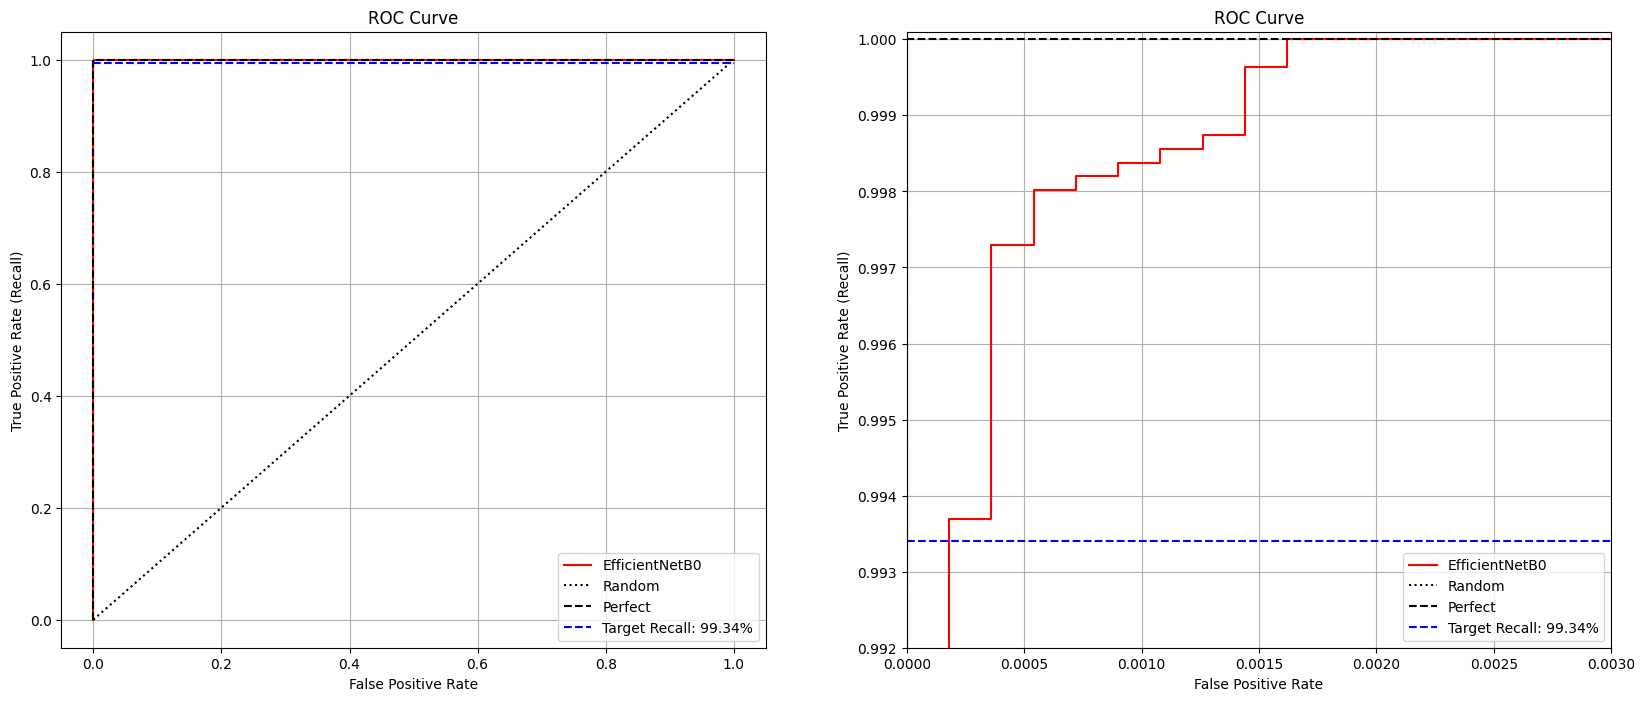

In [11]:
# Evaluate the model for a target recall of 0.9934
TARGET_RECALL = 0.9934
fpr, tpr, thr_roc = roc_curve(y_test, y_pred)
recall_label=f"Target Recall: {round(100*TARGET_RECALL,4)}%"

fig = plt.figure(figsize=(20,8))
ax = fig.add_subplot(121)
plt.plot(fpr, tpr, 'r-', label = 'EfficientNetB0')
plt.plot([0,1],[0,1],'k:', label = 'Random')
plt.plot([0,0,1,1,],[0,1,1,1],'k--', label='Perfect')
plt.plot([0,1],[TARGET_RECALL, TARGET_RECALL],'b--', label=recall_label)
plt.legend(fontsize=10)
plt.title('ROC Curve')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate (Recall)')
plt.grid()

ax = fig.add_subplot(122)
plt.plot(fpr, tpr, 'r-', label = 'EfficientNetB0')
plt.plot([0,1],[0,1],'k:', label = 'Random')
plt.plot([0,0,1,1,],[0,1,1,1],'k--', label='Perfect')
plt.plot([0,1],[TARGET_RECALL, TARGET_RECALL],'b--', label=recall_label)
plt.legend(fontsize=10)
plt.title('ROC Curve')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate (Recall)')
plt.xlim(0.0, 0.003)
plt.ylim(0.992, 1.0001)
plt.grid()
plt.savefig(os.path.join('../images', f'food_nofood_roc_classif_epoch{BEST_EPOCH}.png'), dpi=600)
plt.show()

Threshold for 99.34% recall: 0.9976246953010559
False Positive Rate: 0.02%
Normalized confusion matrix


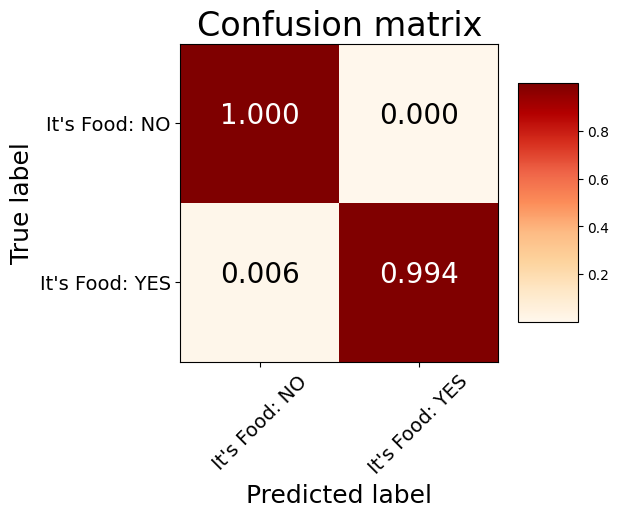

In [12]:
# Compute the threshold to achieve a TARGET_RECALL that produces no false positives
thr, fpr = find_roc_threshold_tpr(y_test, y_pred, TARGET_RECALL)
print(f"Threshold for {round(100*TARGET_RECALL, 2)}% recall: {thr}")
print(f"False Positive Rate: {round(100*fpr, 2)}%")

# Plot confusion matrix
cm = confusion_matrix(y_test, y_pred >= (thr))
plot_confusion_matrix(cm,
                      ['It\'s Food: NO', 'It\'s Food: YES'],
                      normalize=True,
                      title='Confusion matrix',
                      cmap=plt.cm.OrRd,
                      figsize=(6,6))
plt.savefig(os.path.join('../images', f'food_nofood_confusion_nofalsepositives_classif_epoch{BEST_EPOCH}.png'), dpi=600)

With a target recall of 99.3%, only 0.02% of non-food images pass through.

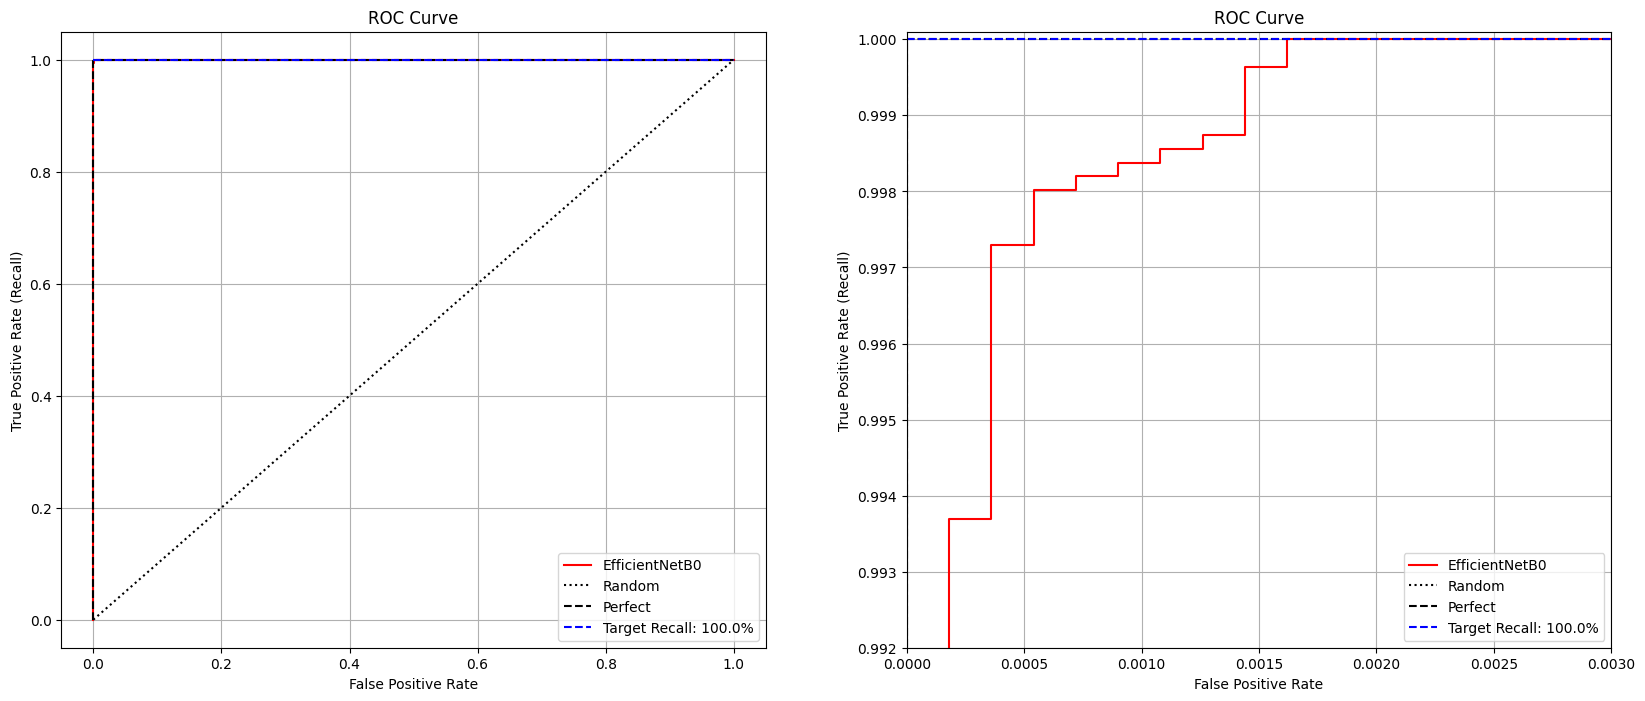

In [13]:
# Evaluate the model for a target recall of 1.0
TARGET_RECALL = 1.0
fpr, tpr, thr_roc = roc_curve(y_test, y_pred)
recall_label=f"Target Recall: {round(100*TARGET_RECALL,4)}%"

fig = plt.figure(figsize=(20,8))
ax = fig.add_subplot(121)
plt.plot(fpr, tpr, 'r-', label = 'EfficientNetB0')
plt.plot([0,1],[0,1],'k:', label = 'Random')
plt.plot([0,0,1,1,],[0,1,1,1],'k--', label='Perfect')
plt.plot([0,1],[TARGET_RECALL, TARGET_RECALL],'b--', label=recall_label)
plt.legend(fontsize=10)
plt.title('ROC Curve')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate (Recall)')
plt.grid()

ax = fig.add_subplot(122)
plt.plot(fpr, tpr, 'r-', label = 'EfficientNetB0')
plt.plot([0,1],[0,1],'k:', label = 'Random')
plt.plot([0,0,1,1,],[0,1,1,1],'k--', label='Perfect')
plt.plot([0,1],[TARGET_RECALL, TARGET_RECALL],'b--', label=recall_label)
plt.legend(fontsize=10)
plt.title('ROC Curve')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate (Recall)')
plt.xlim(0.0, 0.003)
plt.ylim(0.992, 1.0001)
plt.grid()
plt.savefig(os.path.join('../images', f'food_nofood_roc_classif_epoch{BEST_EPOCH}.png'), dpi=600)
plt.show()

Threshold for 100.0% recall: 0.8310611844062805
False Positive Rate: 0.16%
Normalized confusion matrix


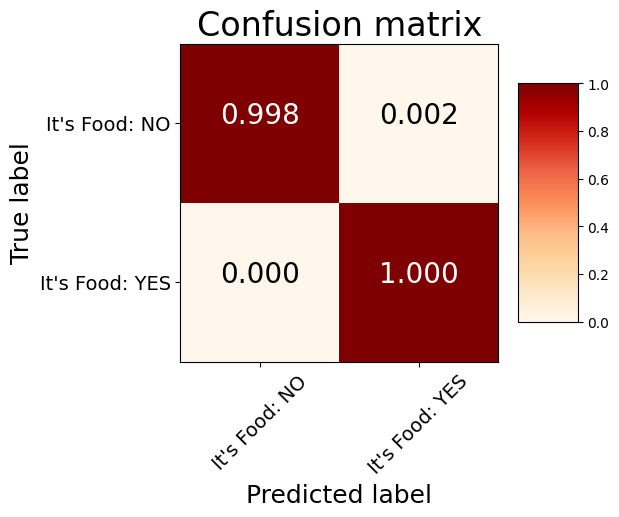

In [16]:
# Compute the threshold for a target recall of 100%
thr, fpr = find_roc_threshold_tpr(y_test, y_pred, TARGET_RECALL)
print(f"Threshold for {round(100*TARGET_RECALL, 2)}% recall: {thr}")
print(f"False Positive Rate: {round(100*fpr, 2)}%")

# Plot confusion matrix
cm = confusion_matrix(y_test, y_pred >= (thr))
plot_confusion_matrix(cm,
                      ['It\'s Food: NO', 'It\'s Food: YES'],
                      normalize=True,
                      title='Confusion matrix',
                      cmap=plt.cm.OrRd,
                      figsize=(6,6))
plt.savefig(os.path.join('../images', f'confusion_classif_nofalsenegatives_epoch{BEST_EPOCH}.png'), dpi=600)

With a target recall of 100%, about 0.2% of non-food images pass through.

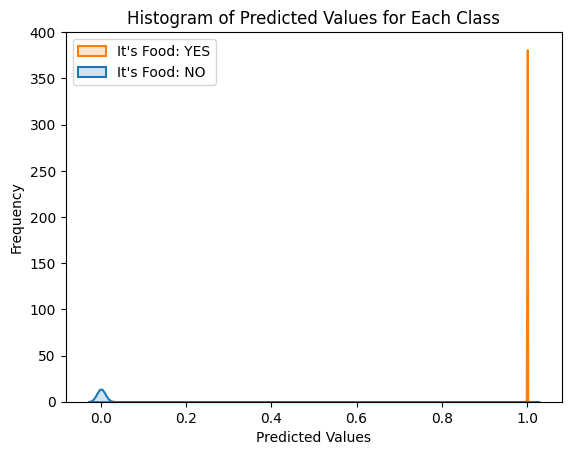

In [24]:
# Plot class distribution
plot_class_distribution(y_test, y_pred)
plt.savefig(os.path.join('../images', f'food_nofood_distribution_classif_epoch{BEST_EPOCH}.png'), dpi=600)

As can be seen in the figure, both classes can be (almost) perfectly classified by the model.